## Frequency response of 2D-waveguide

In [1]:
import fenics as fen
import mshr
import helpers
import numpy as np
import matplotlib.pyplot as plt
import wg2D
import scipy.sparse
import scipy.sparse.linalg

### Plot L2-norm vs oscillation frequency

In [2]:
def get_solution_L2_norms(omegas, K, M, L, bc, V):
    L2_norms = np.empty(len(omegas))
    F = fen.assemble(fen.dot(fen.TrialFunction(V), fen.TestFunction(V))*fen.dx).array()
    for i, omega in enumerate(omegas):
        A_z = wg2D.solve(omega, K, M, L, bc, V).vector().get_local()
        L2_norms[i] = pow(A_z.T @ F @ A_z, 0.5)
    return L2_norms

In [3]:
height = 1.0
width = 5.0
mu = fen.Expression('1.0', degree=2) # 4*np.pi*1e-7 # magnetic permeability inside waveguide
eps = fen.Expression('1.0', degree=2) # 8.854187e-12 # electric permittivity inside waveguide
g_z_inlet = fen.Expression('1.0', degree=2)

In [4]:
# Create waveguide mesh and set boundary
class Inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0) and x[1]>0 and x[1]<height
inlet = Inlet()

domain = mshr.Rectangle(fen.Point(0.0, 0.0), fen.Point(width, height))
         
mesh, boundary, V, bc = wg2D.create(domain, inlet)

In [5]:
# Setup
K, M, L = wg2D.setup(mesh, boundary, g_z_inlet, mu, eps, V)

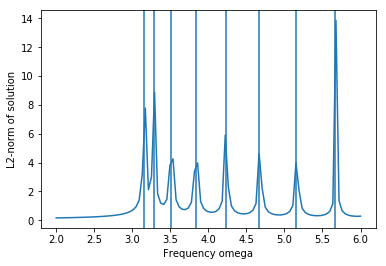

In [18]:
# Observe frequency response
omegas = np.linspace(2, 6, 100)
L2_norms =  get_solution_L2_norms(omegas, K, M, L, bc, V)
plt.plot(omegas, L2_norms)
plt.xlabel('Frequency omega')
plt.ylabel('L2-norm of solution')

# Expected location of peaks
ev = np.sort(np.frompyfunc(lambda n, k: np.pi*pow(n**2/(height)**2 + (k+0.5)**2/(width)**2 , 0.5), 2, 1).outer(1, np.arange(0, 8)).flatten())
[plt.axvline(x) for x in ev]
plt.show()

### First resonant solution

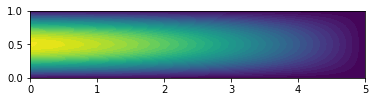

In [32]:
omega = np.pi*pow(1**2/(height)**2 + 0.5**2/(width)**2 , 0.5)
A_z = wg2D.solve(omega, K, M, L, bc, V)
fen.plot(A_z)

### Fifth resonant solution

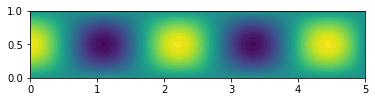

In [34]:
omega = np.pi*pow(1**2/(height)**2 + 4.5**2/(width)**2 , 0.5)
A_z = wg2D.solve(omega, K, M, L, bc, V)
fen.plot(A_z)

### Compute eigenvalues numerically (for unforced system)

In [8]:
K_mat = fen.as_backend_type(fen.assemble(K)).mat()
K_sparse = scipy.sparse.coo_matrix(scipy.sparse.csr_matrix(K_mat.getValuesCSR()[::-1]))
M_mat = fen.as_backend_type(fen.assemble(M)).mat()
M_sparse = scipy.sparse.coo_matrix(scipy.sparse.csr_matrix(M_mat.getValuesCSR()[::-1]))

# ev = scipy.sparse.linalg.eigsh(K_sparse, k=1, M=M_sparse, which='SM') <- This doesn't work
#      It seems as if the smallest eigenvalue (which apparently turns out to be 0) can not be
#      iterated with which='SM'. Using the shift-invert mode seems to fix this problem.
ev = scipy.sparse.linalg.eigsh(K_sparse, k=9, M=M_sparse, sigma=0)
np.sqrt(np.abs(ev[0]))

/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


array([  4.31876682e-08,   6.28341066e-01,   1.25681558e+00,
         1.88557174e+00,   2.51472000e+00,   3.14442495e+00,
         3.14443343e+00,   3.20682120e+00,   3.38719294e+00])

### Compute eigenvalues analytically (for unforced system)

In [9]:
np.sort(np.frompyfunc(lambda n, k: np.pi*pow(n**2/(height)**2 + k**2/(width)**2 , 0.5), 2, 1).outer(np.arange(0, 2), np.arange(0, 5)).flatten())

array([0.0, 0.6283185307179586, 1.2566370614359172, 1.8849555921538759,
       2.5132741228718345, 3.141592653589793, 3.203808448882819,
       3.3835988392928105, 3.6636951272562954, 4.023201612868357], dtype=object)